# Assignment 10
1. Refer to the GRADCAM code we wrote: https://colab.research.google.com/drive/10GugXUNI7ztK2joRZUnYyqRrQbYnOQE0
2. Build GradCAM images for the one layer before the one we used, and one layer before this one. Show the results.
3. Load this image:  https://user-images.githubusercontent.com/15984084/65062738-54a80800-d99a-11e9-9fb9-92a5dc7724a7.jpg
4. "Find"  "sunglasses" in the image using GradCAM


### **Import Libraries and modules**

In [0]:
import numpy as np

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Add, BatchNormalization
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from keras import backend as K

from keras.datasets import mnist

### GRADCAM

Let's start with a pretrained VGG model

In [0]:
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.preprocessing import image
import numpy as np
import cv2

1.  Loading helper functions
2.  Load VGG
3. Load Image
4. Rescale image to 224x224x3 (VGG's expectation, why?)
5. Use expand_dims to convert image to a batch of size 1
6. Preprocesing normalizes our input image by subtracting mean RGB values

In [13]:
model = VGG16(weights="imagenet")
from skimage import io
dog = io.imread("https://www.rspcapetinsurance.org.au/rspca/media/images/hero/dog-insurance-hero.jpg")
dog = cv2.resize(dog, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
x = image.img_to_array(dog)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

553467904/553467096 [==============================] - 16s 0us/step


1. We get the predictions for the image
2. We take the topmost class index
3. Take output from the final convolutional layer

In [14]:
preds = model.predict(x)
class_idx = np.argmax(preds[0])
print(class_idx)
class_output = model.output[:, class_idx]
last_conv_layer = model.get_layer("block5_conv3")

180


1. Compute the gradient of the class output value with respect to the feature map
2. Pool the gradients over all the axies leaving out the channel dimension
3. Weigh the output feature map with the computed gradient values

In [17]:
grads = K.gradients(class_output, last_conv_layer.output)[0]
print(grads.shape)
pooled_grads = K.mean(grads, axis=(0, 1, 2))
print(pooled_grads.shape)
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

pooled_grads_value, conv_layer_output_value = iterate([x])

for i in range(512):
  conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

(?, 14, 14, 512)
(512,)


1. Average the weighted feature map along the channel dimension resulting in a heat map of size 14x14 
2. Normalize the heat map to make the values between 0 and 1

In [18]:
heatmap = np.mean(conv_layer_output_value, axis = -1)
print(conv_layer_output_value.shape)
print(heatmap.shape)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)

(14, 14, 512)
(14, 14)


### Show the results

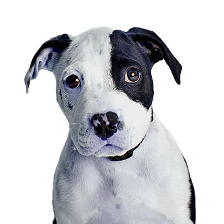

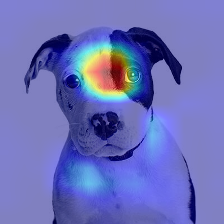

In [19]:
heatmap = cv2.resize(heatmap, (dog.shape[1], dog.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(dog, 0.5, heatmap, 0.5, 0)
from google.colab.patches import cv2_imshow
cv2_imshow( dog)
cv2_imshow(superimposed_img)

## Using the GRADCAM to detect sunglasses 

###GRADCAM
Gradient-weighted Class Activation Mapping (Grad-CAM), uses the gradients of any target concept, flowing into the final convolutional layer to produce a coarse localization map highlighting the important regions in the image for predicting the concept.

###Steps involved: 
1. Load a pre-trained model
2. Load an image which can be processed by this model (224x224 for VGG16 why?)
3. Infer the image and get the topmost class index
4. Take the output of the final convolutional layer
5. Compute the gradient of the class output value w.r.t to L feature maps
6. Pool the gradients over all the axes leaving out the channel dimension
7. Weigh the output feature map with the computed gradients (+ve)
8. Average the weighted feature maps along channels
9. Normalize the heat map to make the values between 0 and 1




In [21]:
# We use model summary to get the layer names
model = VGG16(weights="imagenet")
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

class_idx for sunglasses =  837

Creating the HEAT Map from layer named:  block5_conv1
grads.shape =  (?, 14, 14, 512)
pooled_grads.shape =  (512,)
conv_layer_output_value.shape =  (14, 14, 512)
heatmap.shape =  (14, 14)


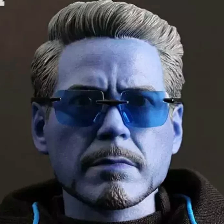

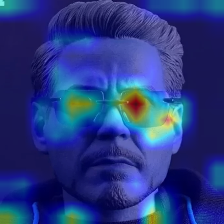




Creating the HEAT Map from layer named:  block5_conv2
grads.shape =  (?, 14, 14, 512)
pooled_grads.shape =  (512,)
conv_layer_output_value.shape =  (14, 14, 512)
heatmap.shape =  (14, 14)


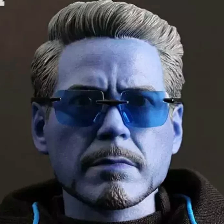

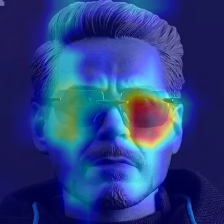

In [33]:
#############################################################
from skimage import io

# Loading the image from the given link
stark = io.imread("https://user-images.githubusercontent.com/15984084/65062738-54a80800-d99a-11e9-9fb9-92a5dc7724a7.jpg")
stark = cv2.resize(stark, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
x = image.img_to_array(stark)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

#############################################################
# Function to create the required HeatMap
def createHeatMap(class_output, last_conv_layer, name_of_layer):
  print("\nCreating the HEAT Map from layer named: ", name_of_layer)
  grads = K.gradients(class_output, last_conv_layer.output)[0]
  print("grads.shape = ", grads.shape)
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  print("pooled_grads.shape = ", pooled_grads.shape)
  iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

  pooled_grads_value, conv_layer_output_value = iterate([x])

  for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

  heatmap = np.mean(conv_layer_output_value, axis = -1)
  print("conv_layer_output_value.shape = ", conv_layer_output_value.shape)
  print("heatmap.shape = ", heatmap.shape)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)


  heatmap = cv2.resize(heatmap, (stark.shape[1], stark.shape[0]))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  superimposed_img = cv2.addWeighted(stark, 0.5, heatmap, 0.5, 0)
  from google.colab.patches import cv2_imshow
  cv2_imshow(stark)
  cv2_imshow(superimposed_img)
  print("\n")

#############################################################
# Class ID for sunglasses is 837
class_idx = 837
print("class_idx for sunglasses = ", class_idx)

class_output = model.output[:, class_idx]
last_conv_layer1 = model.get_layer("block5_conv1")
last_conv_layer2 = model.get_layer("block5_conv2")

# Creating the Heat Map for Layer Named: block5_conv1
createHeatMap(class_output, last_conv_layer1, "block5_conv1")

# Creating the Heat Map for Layer Named: block5_conv2
createHeatMap(class_output, last_conv_layer2, "block5_conv2")
#############################################################